In [1]:
#Import Library OS/Zipfile
import os
import zipfile

local_zip = 'train.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
local_zip = 'valid.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [2]:
# Directory with our training dandelion pictures
train_dandelion_dir = os.path.join('/tmp/train/dandelion')

# Directory with our training grass pictures
train_grass_dir = os.path.join('/tmp/train/grass')

# Directory with our validation dandelion pictures
valid_dandelion_dir = os.path.join('/tmp/valid/dandelion')

# Directory with our validation grass pictures
valid_grass_dir = os.path.join('/tmp/valid/grass')

In [3]:
train_dandelion_names = os.listdir(train_dandelion_dir)
print(train_dandelion_names[:10])

train_grass_names = os.listdir(train_grass_dir)
print(train_grass_names[:10])

validation_dandelion_hames = os.listdir(valid_dandelion_dir)
print(validation_dandelion_hames[:10])

validation_grass_names = os.listdir(valid_grass_dir)
print(validation_grass_names[:10])

['00000000.jpg', '00000001.jpg', '00000002.jpg', '00000003.jpg', '00000004.jpg', '00000005.jpg', '00000006.jpg', '00000007.jpg', '00000008.jpg', '00000009.jpg']
['00000000.jpg', '00000001.jpg', '00000002.jpg', '00000003.jpg', '00000004.jpg', '00000005.jpg', '00000006.jpg', '00000007.jpg', '00000008.jpg', '00000009.jpg']
['00000000.jpg', '00000001.jpg', '00000002.jpg', '00000003.jpg', '00000004.jpg', '00000005.jpg', '00000006.jpg', '00000007.jpg', '00000008.jpg', '00000009.jpg']
['00000000.jpg', '00000001.jpg', '00000002.jpg', '00000003.jpg', '00000004.jpg', '00000005.jpg', '00000006.jpg', '00000007.jpg', '00000008.jpg', '00000009.jpg']


Mencari informasi berapa total images dari dandelion dan rumput di directory :

In [4]:
print('total training dandelion images:', len(os.listdir(train_dandelion_dir)))
print('total training rumput images:', len(os.listdir(train_grass_dir)))
print('total validation dandelion images:', len(os.listdir(valid_dandelion_dir)))
print('total validation rumput images:', len(os.listdir(valid_grass_dir)))

total training dandelion images: 500
total training rumput images: 499
total validation dandelion images: 92
total validation rumput images: 65


In [5]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

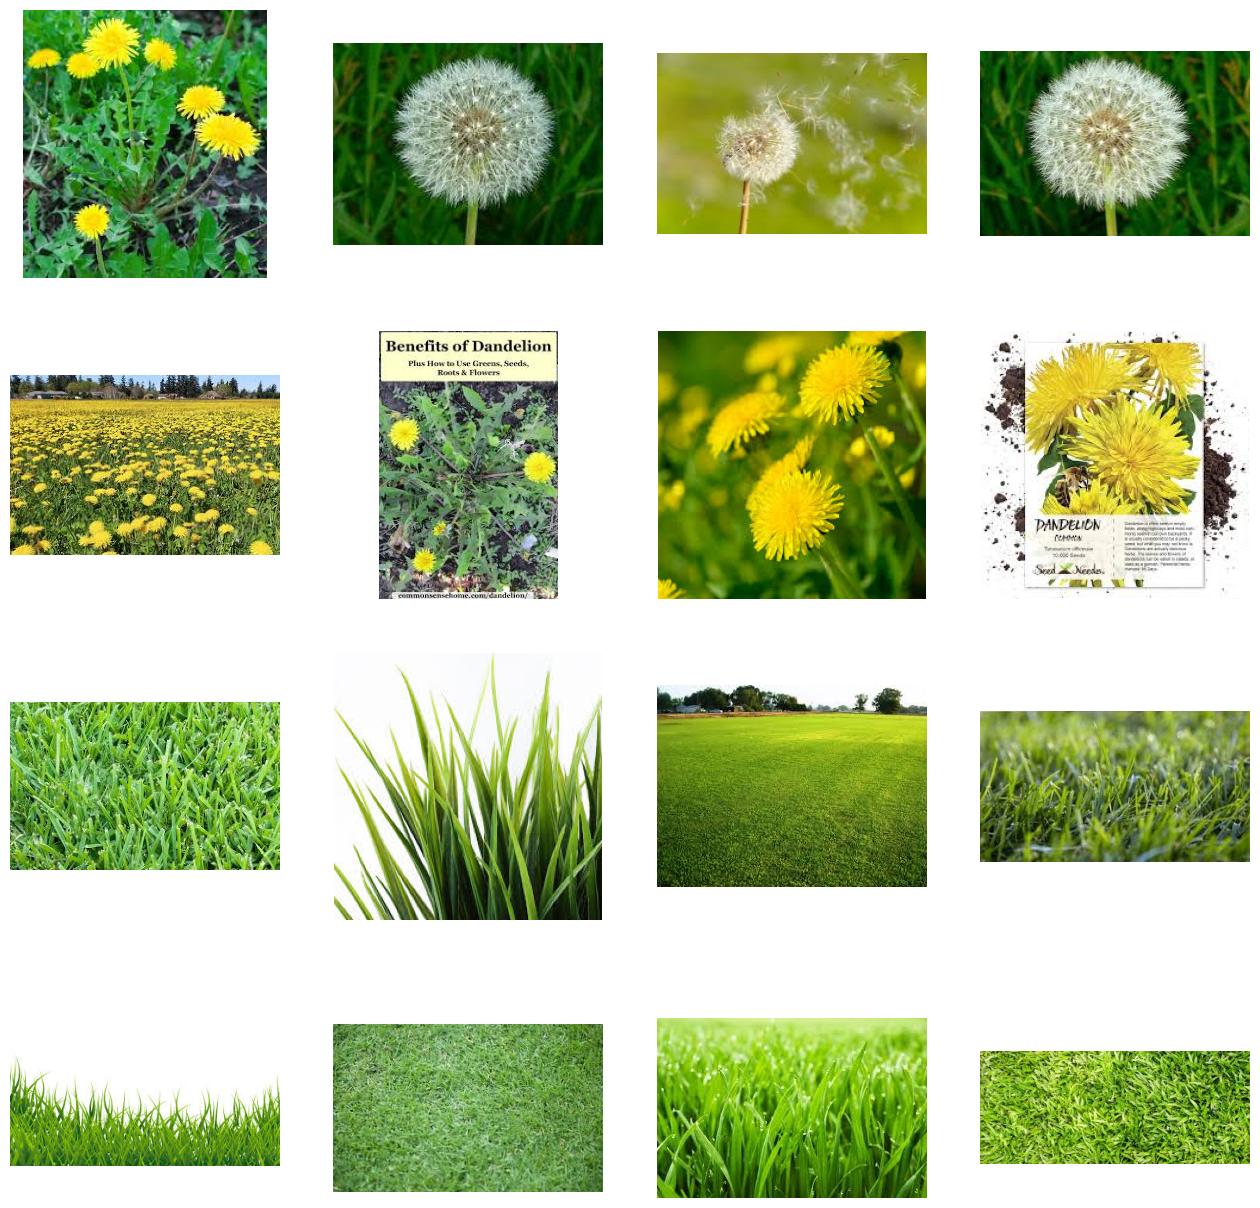

In [6]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_dandelion_pic = [os.path.join(train_dandelion_dir, fname)
                for fname in train_dandelion_names[pic_index-8:pic_index]]
next_grass_pic = [os.path.join(train_grass_dir, fname)
                for fname in train_grass_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_dandelion_pic + next_grass_pic):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 120 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        '/tmp/train/',  # This is the source directory for training images
        classes = ['dandelion', 'grass'],
        target_size=(200, 200),  # All images will be resized to 200x200
        batch_size=120,
        # Use binary labels
        class_mode='binary')

# Flow validation images in batches of 19 using valid_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        '/tmp/valid/',  # This is the source directory for training images
        classes = ['dandelion', 'grass'],
        target_size=(200, 200),  # All images will be resized to 200x200
        batch_size=19,
        # Use binary labels
        class_mode='binary',
        shuffle=False)

Found 999 images belonging to 2 classes.
Found 157 images belonging to 2 classes.


In [8]:
import tensorflow as tf
import numpy as np
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy.interpolate import interp1d
from sklearn.metrics import roc_auc_score

In [10]:
model = tf.keras.models.Sequential([
# Note the input shape is the desired size of the image 200x200 with 3 bytes color
# This is the first convolution
tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(200, 200, 3)),
tf.keras.layers.MaxPooling2D(2, 2),
# The second convolution
tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),
# The third convolution
tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),
# The fourth convolution
tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),
# # The fifth convolution
tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),
# Flatten the results to feed into a DNN
tf.keras.layers.Flatten(),
# 512 neuron hidden layer
tf.keras.layers.Dense(512, activation='relu'),
# Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('dandelions') and 1 for the other ('grass')
tf.keras.layers.Dense(1, activation='sigmoid')
])

c:\Users\Asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 198, 198, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 99, 99, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 97, 97, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 46, 46, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 21, 21, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 622,753 (2.38 MB)

 Trainable params: 622,753 (2.38 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
model.compile(optimizer = tf.optimizers.Adam(),
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

In [13]:
import time
start_time = time.time()
history = model.fit(train_generator,
      steps_per_epoch=8,
      epochs=10,
      verbose=2,
      validation_data = validation_generator,
      validation_steps=2)
print("Running time : --- %s seconds ---" % (time.time() - start_time))


c:\Users\Asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
8/8 - 42s - 5s/step - accuracy: 0.4835 - loss: 0.7103 - val_accuracy: 1.0000 - val_loss: 0.6688
Epoch 2/10


c:\Users\Asus\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


8/8 - 3s - 366ms/step - accuracy: 0.5167 - loss: 0.6904 - val_accuracy: 1.0000 - val_loss: 0.6587
Epoch 3/10
8/8 - 16s - 2s/step - accuracy: 0.5074 - loss: 0.6881 - val_accuracy: 0.4211 - val_loss: 0.7053
Epoch 4/10
8/8 - 2s - 231ms/step - accuracy: 0.4833 - loss: 0.6829 - val_accuracy: 0.0000e+00 - val_loss: 0.8188
Epoch 5/10
8/8 - 11s - 1s/step - accuracy: 0.6485 - loss: 0.6567 - val_accuracy: 0.4000 - val_loss: 0.8054
Epoch 6/10
8/8 - 2s - 206ms/step - accuracy: 0.7917 - loss: 0.5601 - val_accuracy: 0.5789 - val_loss: 0.6302
Epoch 7/10
8/8 - 11s - 1s/step - accuracy: 0.7008 - loss: 0.5822 - val_accuracy: 0.6316 - val_loss: 0.6806
Epoch 8/10
8/8 - 2s - 206ms/step - accuracy: 0.7917 - loss: 0.4813 - val_accuracy: 0.6579 - val_loss: 0.6117
Epoch 9/10
8/8 - 11s - 1s/step - accuracy: 0.7520 - loss: 0.5107 - val_accuracy: 0.8158 - val_loss: 0.3839
Epoch 10/10
8/8 - 1s - 163ms/step - accuracy: 0.7417 - loss: 0.5044 - val_accuracy: 0.6000 - val_loss: 0.4393
Running time : --- 112.9228620529

In [14]:
model.evaluate(validation_generator)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.3956 - loss: 0.9812


[0.7828875780105591, 0.5414012670516968]

In [15]:
STEP_SIZE_TEST=validation_generator.n//validation_generator.batch_size
validation_generator.reset()
preds = model.predict(validation_generator,
                      verbose=1)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step


In [16]:
fpr, tpr, _ = roc_curve(validation_generator.classes, preds)

In [17]:
roc_auc = auc(fpr, tpr)

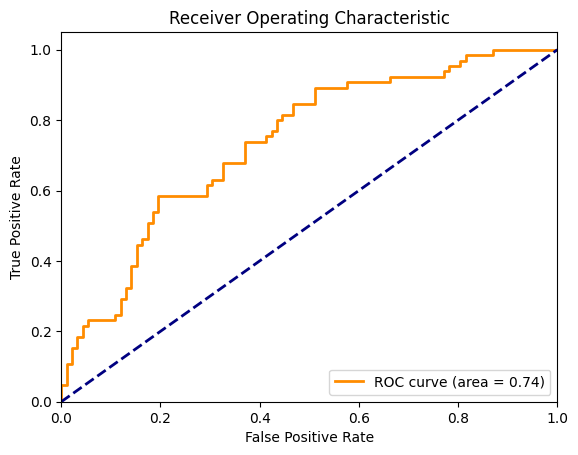

In [18]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

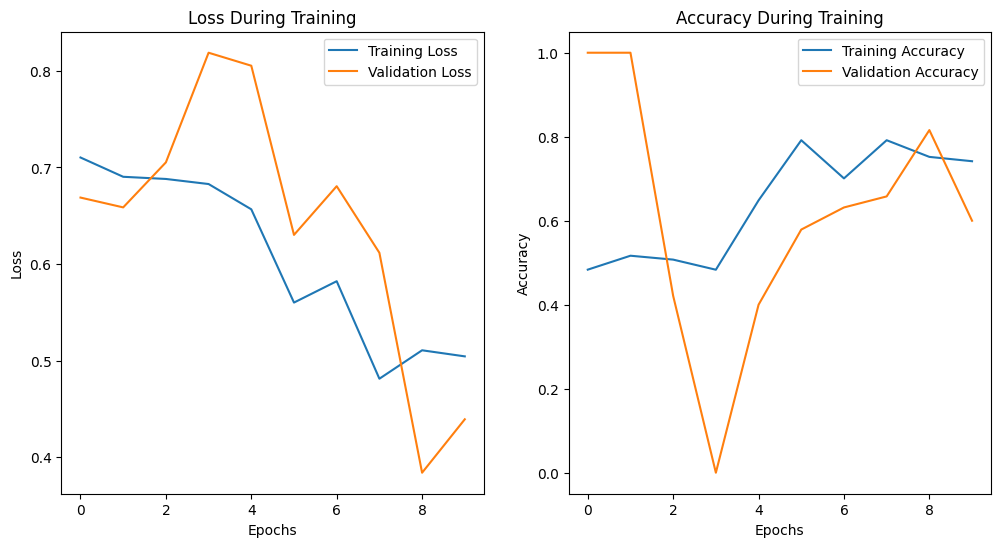

In [19]:
import matplotlib.pyplot as plt

# Asumsi `history` adalah hasil dari model.fit
plt.figure(figsize=(12, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy During Training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [23]:
model.save('model_50.h5')